# Journal 2022-08-22
Looking at ScotRail sound file (see previous journal).  Some context:

"Bizarre FOI find of the day: Scotrail has openly published a two-hour long sound file containing every single element of its automated station announcements (link to file)" -- [@jonbradyphoto](https://twitter.com/jonbradyphoto/status/1560630522002321408)

"If anyone needs this split into 2,440 individual mp3s - because why wouldn't you - I've put them here: https://drive.google.com/drive/folders/172W6sXnvlr7UcNLipO8BTw417_KRz9c5?usp=sharing

And if anyone wants to help transcribe all the files, here's a shared sheet, which has a good chance of descending into chaos" -- [@MattEason](https://twitter.com/MattEason/status/1560653413783744512)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
import cvxpy as cp
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

## ScotRail Announcements
Quick attempt to split the 2hr long mp3 file into separate announcements (see 2022-08-20).

In [3]:
import sox
import librosa
from scipy.ndimage import minimum_filter1d
from IPython.display import Audio

In [4]:
data_dir = os.path.expanduser('~/Work/Data/ScotRail')
sound_file = os.path.join(data_dir, 'ScotRail_Station_Announcements_June2022.mp3')

In [5]:
tfm = sox.Transformer()
announcements = tfm.build_array(sound_file)

In [6]:
sr = sox.file_info.sample_rate(sound_file)
print(f'Sample rate is {sr}')

Sample rate is 16000.0


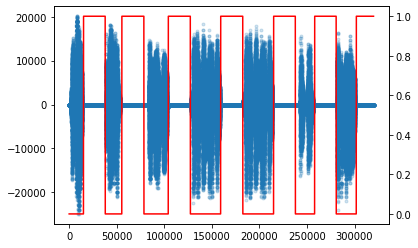

In [7]:
window = int(20*sr)
start = int(0*sr)
sample = announcements[start:start+window]
silence = np.where(sample == -8, 1, 0)
fig, ax = plt.subplots()
ax_r = ax.twinx()
_ = ax.plot(sample, linestyle='none', marker='.', alpha=0.2)
# _ = ax_r.plot(silence, c='r')
# _ = ax_r.plot(np.diff(silence), c='g')
_ = ax_r.plot(minimum_filter1d(silence, size=800), c='r')

In [8]:
def get_silences(signal, window_size=800):
    """Return indexes of periods of silence start and end 
    Default window size is 0.05s i.e. a silence needs to be at least this long
    to be counted
    """
    silence = minimum_filter1d(np.where(signal == -8, 1, 0), size=window_size)
    silence_change = np.diff(silence)
    silence_start = np.where(silence_change == 1)[0]
    silence_end = np.where(silence_change == -1)[0]
    return silence_start, silence_end

In [9]:
silence_start, silence_end = get_silences(announcements)

In [10]:
print(silence_start.shape, silence_end.shape)

(2443,) (2443,)


In [11]:
def create_metadata(announcements, sr, silence_start, silence_end):
    df_announcements = pd.DataFrame(
        np.vstack(
            [np.concatenate([[0], silence_end]), 
             np.concatenate([silence_start, [len(announcements)]])
            ]).T.tolist(),
        columns=['start_ind', 'end_ind']
    ).assign(
        length_samples=lambda x: (x['end_ind'] - x['start_ind']), 
        length_sec=lambda x: x['length_samples']/sr
    )
    return df_announcements

df_announcements = create_metadata(announcements, sr, silence_start, silence_end)

df_announcements.head()

,start_ind,end_ind,length_samples,length_sec
0,0,15015,15015,0.938438
1,37843,55311,17468,1.091750
2,78519,104149,25630,1.601875
3,127349,159223,31874,1.992125
4,182484,214884,32400,2.025000


In [12]:
df_announcements.tail()

,start_ind,end_ind,length_samples,length_sec
2439,121185045,121208176,23131,1.445688
2440,121231165,121249165,18000,1.125000
2441,121272072,121289900,17828,1.114250
2442,121313282,121330540,17258,1.078625
2443,121353796,121364928,11132,0.695750


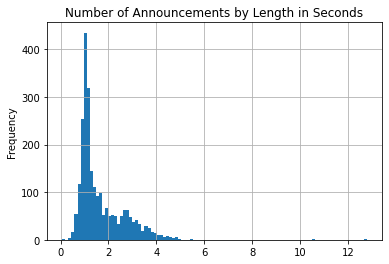

In [13]:
_ = df_announcements.length_sec.plot(
    kind='hist', bins=100, grid=True,
    title='Number of Announcements by Length in Seconds', 
)

In [14]:
df_announcements.describe()

,start_ind,end_ind,length_samples,length_sec
count,2.444000e+03,2.444000e+03,2444.000000,2444.000000
mean,6.440681e+07,6.443332e+07,26505.852291,1.656616
std,3.569578e+07,3.569053e+07,15261.241108,0.953828
min,0.000000e+00,1.501500e+04,1122.000000,0.070125
25%,3.225831e+07,3.227520e+07,16165.250000,1.010328
50%,6.945965e+07,6.947576e+07,19647.500000,1.227969
75%,9.562205e+07,9.563933e+07,34422.750000,2.151422
max,1.213538e+08,1.213649e+08,204633.000000,12.789563


In [15]:
df_announcements.length_sec.quantile([0.05, 0.5, 0.99])

0.05    0.763869
0.50    1.227969
0.99    4.444530
Name: length_sec, dtype: float64

Interesting distribution of announcements - the overall count looks about right, would be nice to understand the couple of long announcements.  

In [16]:
df_announcements.loc[4, ['start_ind', 'end_ind']].astype(int).to_list()

[182484, 214884]

In [17]:
def get_announcement(ind, sound_array=None, df=None):
    start_ind, end_ind = df.loc[ind, ['start_ind', 'end_ind']].astype(int).to_list()
    signal = sound_array[start_ind:end_ind]
    return signal

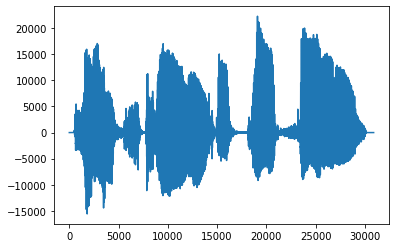

In [18]:
_ = plt.plot(get_announcement(10, announcements, df_announcements))

In [19]:
Audio(get_announcement(0, announcements, df_announcements), rate=sr, autoplay=True)

Looks like getting the individual announcements is working, as is playing using Jupyter Audio.  Now, what are the
long announcements?

In [20]:
df_announcements.loc[df_announcements.length_sec > 6, :]

,start_ind,end_ind,length_samples,length_sec
160,9529955,9734588,204633,12.789563
161,9738485,9908023,169538,10.596125


'Attention please: here is a special announcement.  Penalty fares are in operation in this area.  All passengers must be in posession of a valid ticket or authority to travel before traveling on services from this station'

In [21]:
Audio(get_announcement(160, announcements, df_announcements), rate=sr, autoplay=True)

'If you are asked to produce a ticket and are unable to do so you will be liable to pay a penalty fare ore the full standard single fare, whichever is greater'

In [22]:
Audio(get_announcement(161, announcements, df_announcements), rate=sr, autoplay=True)

Wrap this all up in an object for ease of use

In [23]:
class ScotRailAnnouncements:
    def __init__(self, sound_file=None, sound_array=None, sample_rate=None, metadata=None):
        tfm = sox.Transformer()
        self.announcements = sound_array if (sound_array is not None) else tfm.build_array(sound_file)
        self.sr = sample_rate or sox.file_info.sample_rate(sound_file)
        self.df_meta = (
            metadata if (metadata is not None) else 
            create_metadata(self.announcements, self.sr, *get_silences(announcements)))
        
    def get(self, ind):
        return get_announcement(ind, self.announcements, self.df_meta)
    
    def play(self, ind):
        _ = plt.plot(self.get(ind))
        return Audio(self.get(ind), rate=self.sr, autoplay=True)

In [24]:
# scot_rail = ScotRailAnnouncements(sound_file)   # Load file and process
scot_rail = ScotRailAnnouncements(
    sound_array=announcements, sample_rate=sr, metadata=df_announcements
)   # Use already loaded

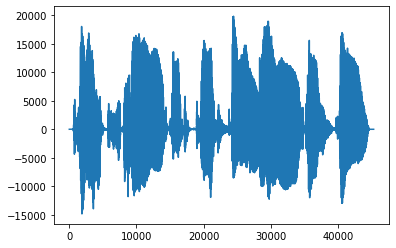

In [25]:
scot_rail.play(11)

In [26]:
scot_rail.df_meta.sort_values('length_sec').head(10)

,start_ind,end_ind,length_samples,length_sec
1648,87643990,87645112,1122,0.070125
1394,76137919,76144391,6472,0.404500
737,37757991,37764815,6824,0.426500
1395,76167402,76174268,6866,0.429125
1407,76596050,76603827,7777,0.486063
1172,67266982,67274935,7953,0.497063
1389,75957601,75965820,8219,0.513687
538,28310239,28318561,8322,0.520125
1245,70411406,70419885,8479,0.529937
1391,76029506,76038053,8547,0.534188


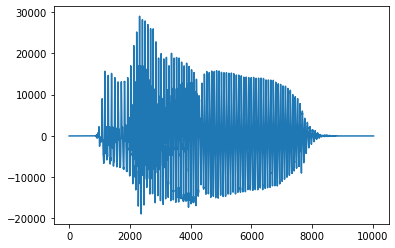

In [27]:
# Ooh - numbers from 1 to 10 are from ind 1164 to 1174
scot_rail.play(1164)